### Spectral analysis on simulated data

We can simulate EEG-like data using the GDa package using the methods in **GDa.signal.simulate_data**, this data can be used to test different methods. In the current notebook we use simulated data to test the spectral analysis methods.

In [3]:
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
from   tqdm                      import tqdm
from   GDa.spectral_analysis     import time_frequency as tf
from   GDa.signal.simulate_data  import white_noise, pink_noise, \
                                        ongoing_non_stationary, \
                                        transient_oscillation_gauss, transient_oscillation_gauss_non_stationary

#### Routine to visualize the data

In [4]:
def plot_data(data_array, chan, fs, n):
    assert type(data_array)==xr.core.dataarray.DataArray, 'Data should be an xarray'
    plt.subplot2grid( (3,3), (0,0), colspan=3 )
    for i in range(data_array.shape[0]):
        plt.plot(data_array.time.values, data_array[i,chan,:], color='b', lw=.2)
    plt.plot(data_array.time.values, data_array[:,chan,:].mean(dim='trials'), color = 'r', lw=3)
    plt.xlim([data_array.time.values.min(), data_array.time.values.max()])
    plt.ylabel('Amplitude', fontsize=12)
    plt.xlabel('Time (s)', fontsize=12)
    plt.subplot2grid( (3,3), (1,0) )
    plt.hist(data_array[:,:,:].values.flatten(), 50)
    plt.ylabel('#', fontsize=12)
    plt.xlabel('Amplitude', fontsize=12)    
    plt.subplot2grid( (3,3), (1,1), colspan=2 )
    data_fft = np.fft.fft( data_array[:,chan,:].values, axis = -1)
    s = np.abs(data_fft) / n
    s[1:] = 2*s[1:]
    f = np.linspace(0,fs/2,n//2)
    plt.plot(f, s.real.mean(axis=0)[:n//2])
    plt.xlim([0,f.max()])
    plt.ylabel('Periodogram', fontsize=12)
    plt.xlabel('Freq (Hz)', fontsize=12)
    plt.subplot2grid( (3,3), (2,0), colspan=3 )
    W = tf.wavelet_transform(data = data_array.values, fs = fs, freqs = np.linspace(5,f.max(),100), n_cycles = 6.0, 
                      time_bandwidth = None, delta = 1, method = 'multitaper', 
                      baseline_correction = False, n_jobs = -1)
    S = np.squeeze( W * np.conj(W) ).real
    plt.imshow(S.mean(axis=0), aspect='auto', cmap='jet', origin='lower', 
           extent=[data_array.time.min(),data_array.time.max(),f[0],f[-1]])
    plt.ylabel('Freq (Hz)', fontsize=12)
    plt.xlabel('Time (s)', fontsize=12)
    plt.tight_layout()

### 1. White noise

White noise can be drawn either from uniform or normal distributions

#### Uniform

In [3]:
signal = white_noise(trials=10, nvars=1, n=1000, fs=250, amp=1, ntype='uniform')

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.1s finished


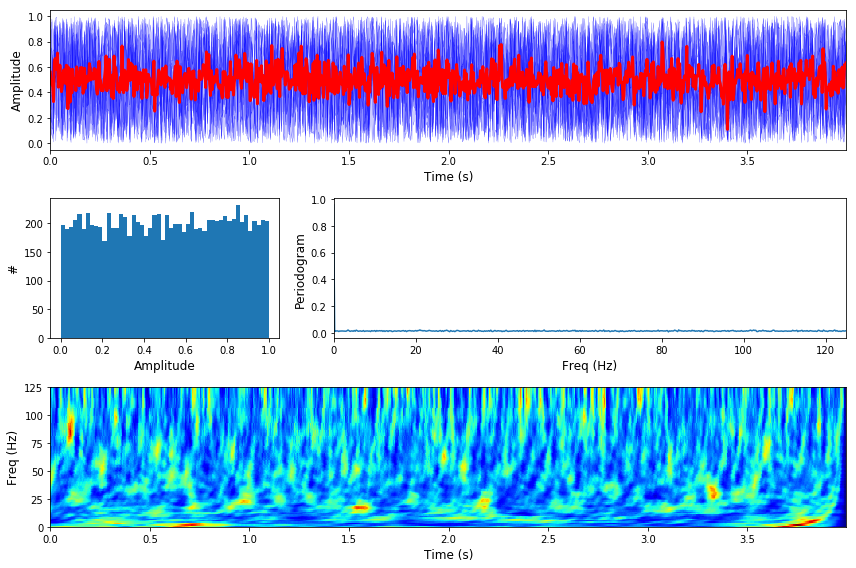

In [4]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

#### Normal

In [5]:
signal = white_noise(trials=10, nvars=1, n=1000, fs=250, amp=1, ntype='normal')

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.6s finished


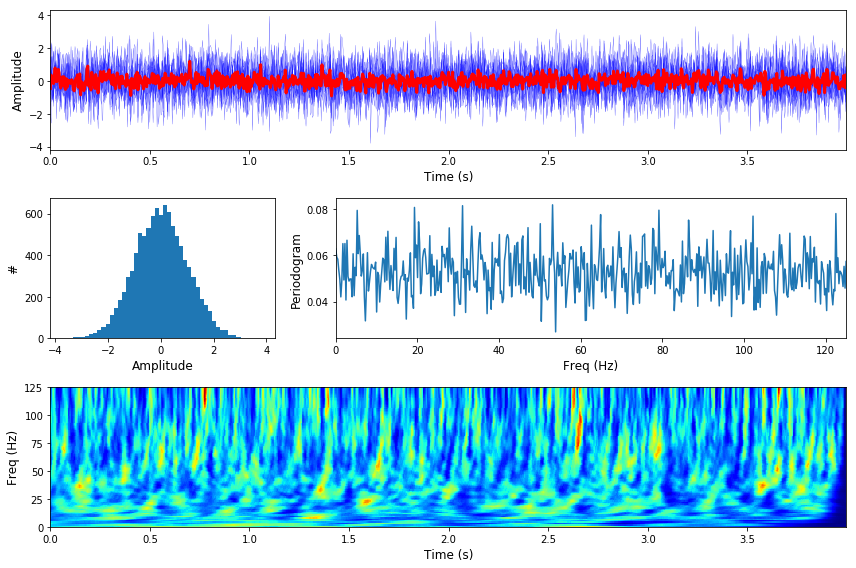

In [6]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 2. Pink noise

In [7]:
signal = pink_noise(trials=10, nvars=1, n=1000, fs=250, tau=50)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.6s finished


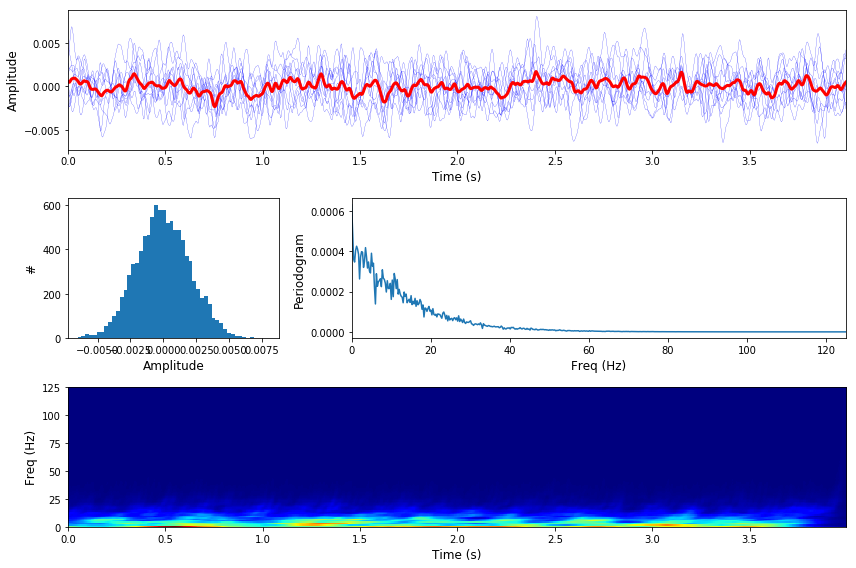

In [8]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 3. Ongoing non-stationary signal

In [9]:
signal = ongoing_non_stationary(trials=10, nvars=1, n=1000, fs=250, 
                                peakfreq=np.array([10, 60]), 
                                fwhm=np.array([10, 10]))

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.6s finished


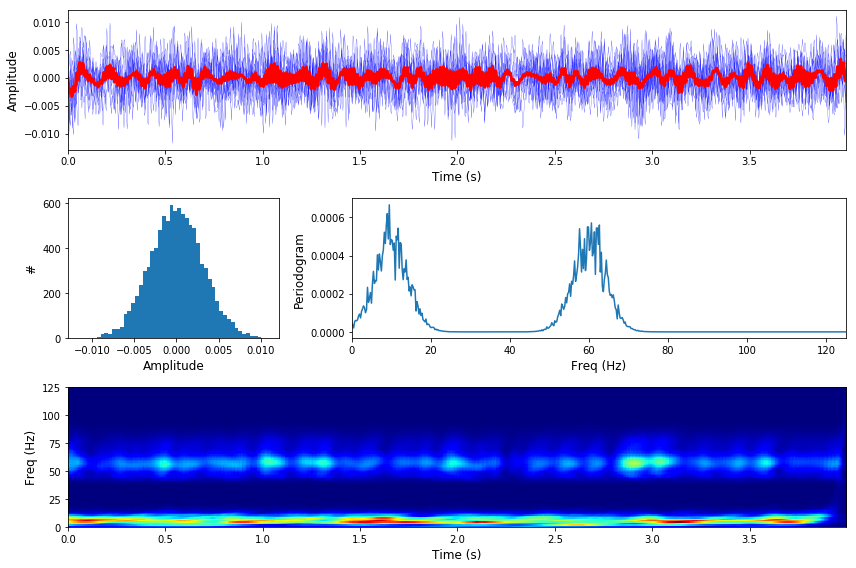

In [10]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 4. Transient oscillation with Gaussian

In [11]:
signal = transient_oscillation_gauss(trials=10, nvars=1, n=1000, fs=250, sin_freq=50, 
                                      peaktime=np.array([1,3]), width=np.array([.2,.2]), 
                                      phaselocked=False)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.6s finished


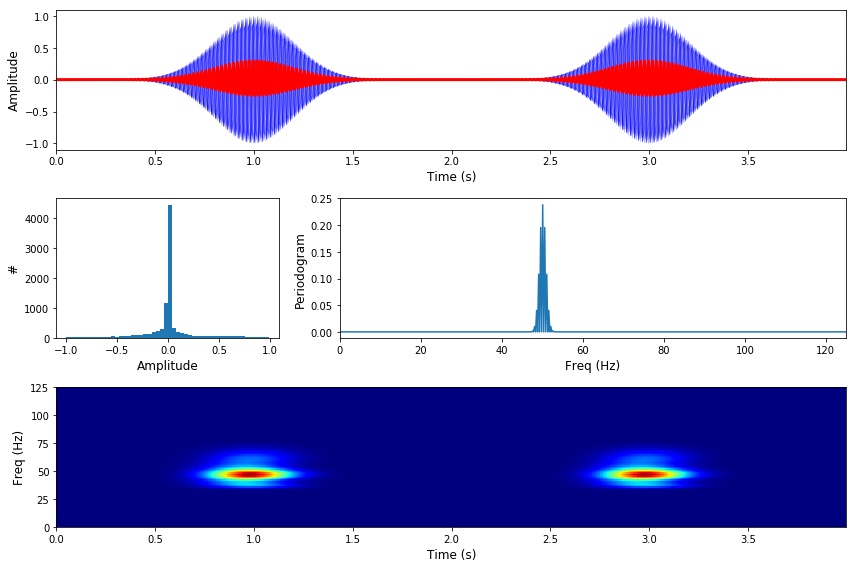

In [12]:
plt.figure(figsize=(12,8))
plot_data(signal, 0,250,1000)

### 5. Transcient non-stationary  signal

In [13]:
signal = transient_oscillation_gauss_non_stationary(trials=10, nvars=1, n=200, fs=60, 
                                                    peakfreq=np.array([21]), fwhm=np.array([5]), 
                                                    peaktime=np.array([1]), width=np.array([0.2]))

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished


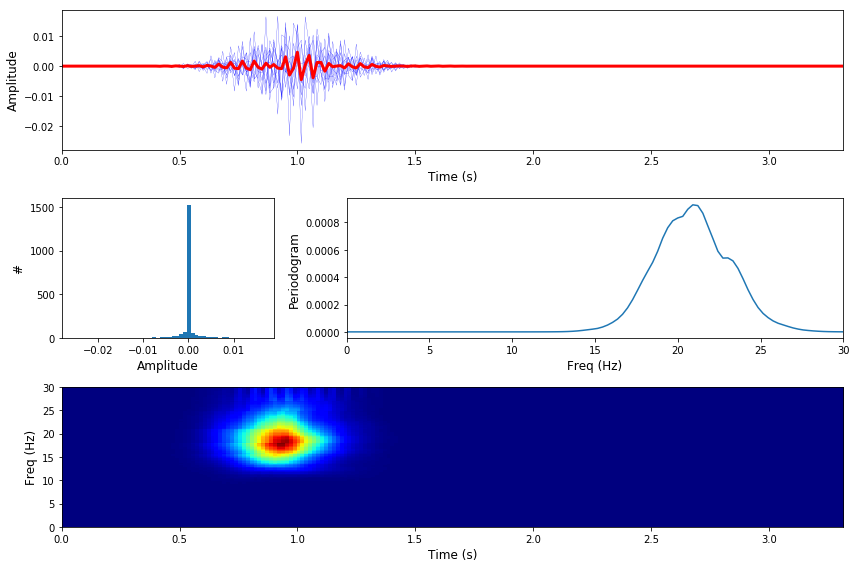

In [14]:
plt.figure(figsize=(12,8))
plot_data(signal,0,60,200)

### Measuring coherence using multitaper technique

To compute the coherence first the cross ($S_{12}(f,t)$), and auto-spectogram ($S_{11}(f,t)$ and $S_{22}(f,t)$) are computed. The coherence is defined as:

$C_{12}(f,t) = \frac{S_{12}S_{12}^{*}}{[S_{11}S_{22}]^{1/2}}$

However, for the equation above $C_{12}(f,t)=1$ $\forall \text{  } f, \text{ and } t$. Therefore, before taking the ratio in the equation above some temporal and frequency smoothing should be done. To do this, we convolve the auto- and cross-spectogram with a square window of size $w_f$, and $w_rt$, for the frequency and time axis, respectively.

Let's $g(w_t,w_f)$ be the filter, and $\tilde{g}(w_t,w_f)$ its representation in the frequency domain. We can then convolve each spectra with $g$, which gives:

$C_{12}(f,t) = \frac{\tilde{g}*(S_{12}S_{12}^{*})}{[\tilde{g}*(S_{11})\tilde{g}*(S_{22})]^{1/2}}$

Note that we ommit the dependencies on $f$ and $t$ for the spectra, and on $w_t$ and $w_f$ for the filter.

To estimate the coherence (or spectra) in given bands we can use the multitaper method. Supose that we have the center frequencies of each band $f_c = \{f_{0},\dots, f_{n}\}$, where $n$ is the number of bands, and the bandwidth of each band $\delta f = \{\delta f_{0},\dots,\delta f_{n}\}$.

If $t_b$ is the time bandwidth of the Multitaper transform, the number of cycles can be computed by:

$n_\rm{cycles} = t_b\frac{f_c}{\delta f}$



This can be used to compute the spctra (and the coherence) directly in each band of interest.

First, let's create two signal with localized burts. The first signal with a burst at $1$ s and $3$ s, and the second with a burst only at $3$ s (both with the same width).

In [5]:
T  = 3
fs = 1000       # Sampling frequency
n  = fs*T       # Number of observations

freqs = np.linspace(0.1, 100, 50)
'''
x = transient_oscillation_gauss(trials=10, nvars=1, n=n, fs=fs, sin_freq=8, 
                                 peaktime=np.array([1,5,10]), width=np.array([1,1,1]), 
                                 phaselocked=False)
y = transient_oscillation_gauss(trials=10, nvars=1, n=n, fs=fs, sin_freq=8, 
                                 peaktime=np.array([5,10]), width=np.array([1,1]), 
                                 phaselocked=False)

x = ongoing_non_stationary(trials=10, nvars=1, n=n, fs=fs, 
                                peakfreq=np.array([60]), 
                                fwhm=np.array([10, 10]))
y = ongoing_non_stationary(trials=10, nvars=1, n=n, fs=fs, 
                                peakfreq=np.array([60]), 
                                fwhm=np.array([10]))
'''

x = transient_oscillation_gauss_non_stationary(trials=10, nvars=1, n=n, fs=fs, 
                                               peakfreq=np.array([21]), fwhm=np.array([5]), 
                                               peaktime=np.array([2]), width=np.array([.2]))

y = transient_oscillation_gauss_non_stationary(trials=10, nvars=1, n=n, fs=fs, 
                                               peakfreq=np.array([21]), fwhm=np.array([5]), 
                                               peaktime=np.array([2]), width=np.array([.2]))

x_noise = pink_noise(trials=10, nvars=1, n=n, fs=fs, tau=50)
y_noise = pink_noise(trials=10, nvars=1, n=n, fs=fs, tau=10) 

signal = xr.DataArray(np.zeros([10,2,n]), dims=("trials", "roi", "time"),
                      coords = {"time": x.time.values})
signal[:,0,:] = np.squeeze( x.values + x_noise.values )
signal[:,1,:] = np.squeeze( y.values + y_noise.values )

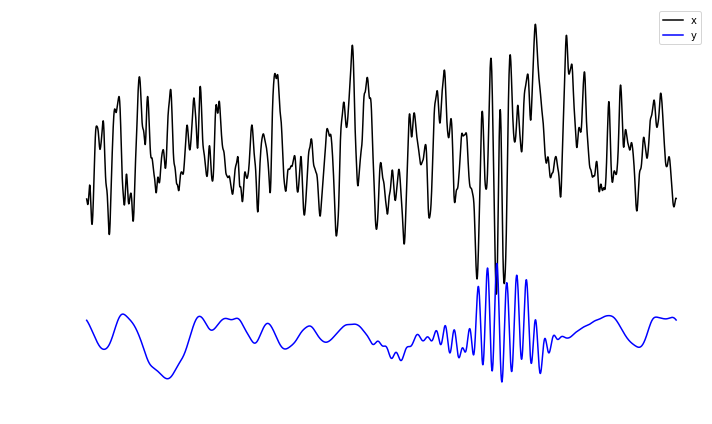

In [6]:
# Plotting ERP of each signal
plt.figure(figsize=(10,6))
plt.plot(signal.time, np.squeeze(signal.mean(dim="trials")).sel(roi=0), 'k')
plt.plot(signal.time, np.squeeze(signal.mean(dim="trials")).sel(roi=1)-0.001, 'b')
plt.legend(['x', 'y'])
plt.axis('off')
plt.tight_layout()

In [17]:
Wx = tf.wavelet_transform(data = signal[:,0,:].values[:,None,:], fs = fs, freqs = freqs, n_cycles = freqs/2, 
                      time_bandwidth = None, delta = 15, method = 'morlet', 
                      baseline_correction = False, n_jobs = -1)
Wy = tf.wavelet_transform(data = signal[:,1,:].values[:,None,:], fs = fs, freqs = freqs, n_cycles = freqs/2, 
                      time_bandwidth = None, delta = 15, method = 'morlet', 
                      baseline_correction = False, n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.3s finished


In [18]:
def smooth_spectra(spectra, win_time, win_freq, fft=False, axes = 0):
    if len(spectra.shape) == 2:
        kernel = np.ones([win_freq, win_time])
    elif len(spectra.shape) == 3:
        kernel = np.ones([1, win_freq, win_time])
        
    #print(kernel.shape)
    
    if fft == True:
        return scipy.signal.fftconvolve(spectra, kernel, mode='valid', axes= axes)
    else:
        return scipy.signal.convolve2d( spectra, kernel, mode='valid', axes = axes) 

In [19]:
np.squeeze(  (Wx*np.conj(Wx)) ).shape

(10, 50, 200)

In [26]:
Sxx = smooth_spectra( np.squeeze(  (Wx*np.conj(Wx)) ), 30, 1, fft=True, axes=(1,2) )
Syy = smooth_spectra( np.squeeze(  (Wy*np.conj(Wy)) ), 30, 1, fft=True, axes=(1,2) )
Sxy = smooth_spectra( np.squeeze(  (Wx*np.conj(Wy)) ), 30, 1, fft=True, axes=(1,2) )
C   = np.abs(Sxy)**2 / ( Sxx * Syy ) 

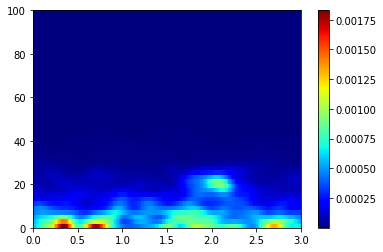

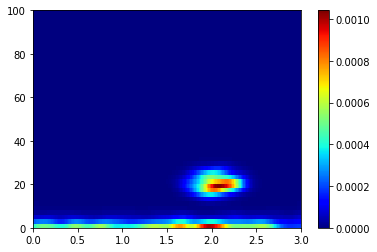

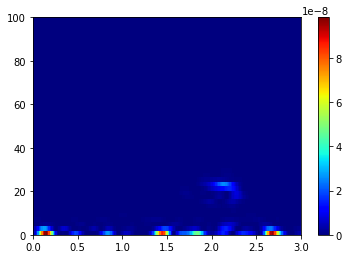

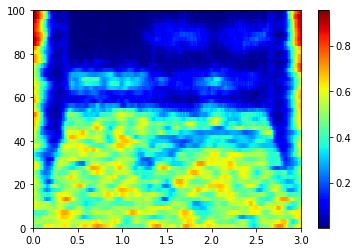

In [27]:
plt.imshow(Sxx.mean(axis=0).real, aspect='auto', cmap='jet', origin='lower',
           extent=[0,T,freqs[0],freqs[-1]]); plt.colorbar()
plt.figure()
plt.imshow(Syy.mean(axis=0).real, aspect='auto', cmap='jet', origin='lower',
           extent=[0,T,freqs[0],freqs[-1]]); plt.colorbar()
plt.figure()
plt.imshow(np.abs(Sxy.mean(axis=0).real)**2, aspect='auto', cmap='jet', origin='lower',
           extent=[0,T,freqs[0],freqs[-1]]); plt.colorbar()
plt.figure()
plt.imshow(np.abs( C.mean(axis=0) ), aspect='auto', cmap='jet', origin='lower',
           extent=[0,T,freqs[0],freqs[-1]]); plt.colorbar()

In [69]:
start = time.time()

tf.wavelet_coherence(data = signal.values, pairs = np.array([[0,1]]), fs = fs, 
                     freqs = freqs, n_cycles = freqs/2, time_bandwidth = None, 
                     delta = 15, method = 'morlet', win_time = 30, win_freq = 1, 
                     dir_out = 'data',n_jobs = 1)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


Elapsed time to load super-tensor: 0.7233715057373047 sec.


[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    0.6s finished


In [70]:
with h5py.File('data/ch1_0_ch2_1.h5', 'r') as hf:
    coh = np.array(hf.get('coherence'))

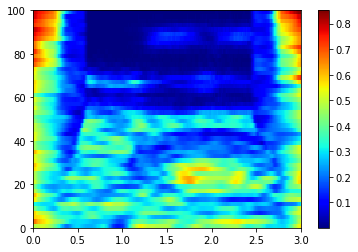

In [71]:
plt.imshow( np.nanmean(coh, axis=0), aspect='auto', cmap='jet', origin='lower',
           extent=[0,T,freqs[0],freqs[-1]]); plt.colorbar()

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.6s finished
/home/vinicius/.local/lib/python3.6/site-packages/joblib/parallel.py:748: UserWarning: The backend class 'SequentialBackend' does not support timeout. You have set 'timeout=1000000.0' in Parallel but the 'timeout' parameter will not be used.
  self.timeout))


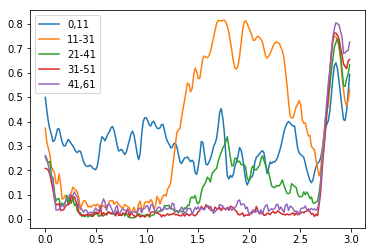

In [7]:
f_l = ['0,11','11-31','21-41','31-51', '41,61']
f_c = np.array([11,21,31,41,51])
d_f = np.ones_like(f_c) * 15
t_b = 8.0
n_cycles = t_b * f_c / d_f

tf.wavelet_coherence(data = signal.values, pairs = np.array([[0,1]]), fs = fs, 
                     freqs = f_c, n_cycles = n_cycles, time_bandwidth = t_b, 
                     delta = 15, method = 'multitaper', win_time = 10, win_freq = 1, 
                     dir_out = 'data',n_jobs = 1)

with h5py.File('data/ch1_0_ch2_1.h5', 'r') as hf:
    coh = np.array(hf.get('coherence'))
    
coh = np.nanmean(coh, axis=0)

for i in range(len(f_c)):
    plt.plot(signal.time.values[::15],coh[i,:], label=f_l[i])
plt.legend()

In [41]:
coh.shape

(10, 5, 181)

In [50]:
Sxx, Syy, Sxy = tf.gabor_spectrum(signal1 = x.values[0,0], signal2 = y.values[0,0], fs = fs, freqs = freqs,
                  win_time = 1, win_freq = 1, n_cycles = 6.0)

ValueError: axes exceeds dimensionality of input

In [53]:
x.values[0].shape

(1, 2500)

TypeError: Invalid dimensions for image data

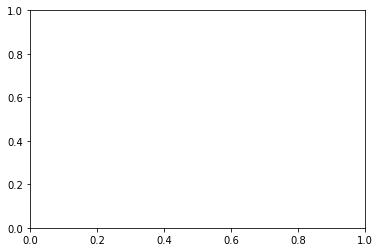

In [51]:
plt.figure()
plt.imshow(Sxx.real, aspect='auto', cmap='jet', origin='lower',
          extent=[x.time[0],x.time[-1],freqs[0], freqs[-1]])
plt.figure()
plt.imshow(Syy.real, aspect='auto', cmap='jet', origin='lower',
          extent=[x.time[0],x.time[-1],freqs[0], freqs[-1]])
plt.figure()
plt.imshow(np.abs(Sxy)**2, aspect='auto', cmap='jet', origin='lower',
          extent=[x.time[0],x.time[-1],freqs[0], freqs[-1]])

In [48]:
C = tf.gabor_coherence(signal1 = x.values[0,0], signal2 = y.values[0,0], fs = fs, freqs = freqs,
                win_time = 1, win_freq = 1, n_cycles = 6.0)

In [49]:
C.shape

(100, 1000)

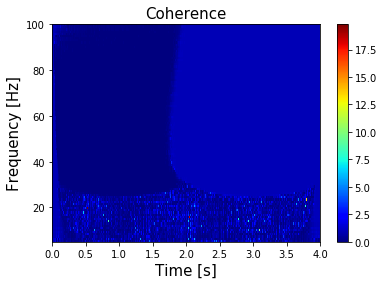

In [50]:
plt.imshow(C.real, aspect='auto', cmap='jet', origin='lower',
           extent=[x.time[0],x.time[-1],freqs[0], freqs[-1]], vmin=0)
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [s]', fontsize=15)
plt.title('Coherence', fontsize=15)
plt.colorbar()

### How parameters influences

Next we analyse how the temporal and frequency smoothing influences the coherence computation. The other parameters such as down-sampling factor ($\Delta$) and number of cycles ($\lambda$) are maintained fixed: $\Delta = 15$ and $\lambda = f_c/2$, where $f_c$ are the center frequencies used.

One important thing to note is: what is the duration of the smoothing window in time?

If $f_s$ is the original sampling frequency of the signal, with a down-sampling factor of $\Delta$, and the time-smoothing window of $w_t$ is given in bins, its respective time-length is simply:

$w_t^{'} = w_t \Delta/f_s$

To demonstrate the influence of the dimensions of the filter $g$ in the coherence estimation we will use the combination of the following values for $w_t$ and $w_f$, respectively: $w_t=\{1, 10, 30, 70\}$, $w_t=\{1, 3, 5\}$. Notice that we use the values of $w_t$ and $w_f$ in bins but their respective length in time can be obtained using 
the equation above.

Below we show the results for the Morlet and Multitaper methods, respectively.

In [30]:
x.values[0,0].shape

(750,)

#### Morlet

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   33.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   33.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   32.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   32.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   33.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   33.0s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   33.1s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   33.1s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parall

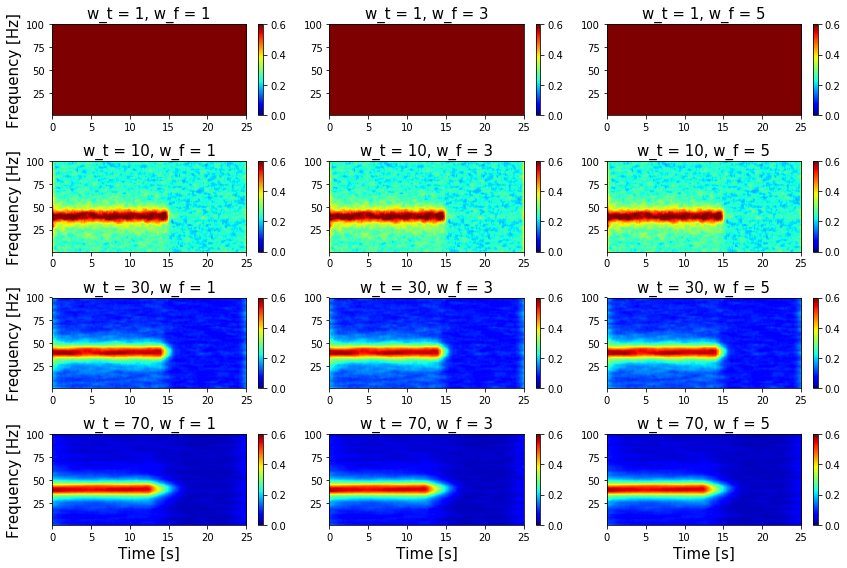

In [22]:
plt.figure(figsize=(12,8))
count = 1
for i in range(len(win_time)):
    for j in range(len(win_freq)):
        time_frequency.wavelet_coherence(data = X.values, pairs = np.array([[0,1]]), fs = Fs, 
                                 freqs = freqs, n_cycles = freqs/2, time_bandwidth = None, 
                                 delta = 15, method = 'morlet', win_time = win_time[i], win_freq = win_freq[j], 
                                 dir_out = 'data', n_jobs = -1)

        with h5py.File('data/ch1_0_ch2_1.h5', 'r') as hf:
            coh = np.array(hf.get('coherence'))
            
        plt.subplot(len(win_time), len(win_freq), count)
        plt.imshow(coh.mean(axis=0), aspect='auto', cmap='jet', origin='lower',
                   extent=[X.time[0],X.time[-1],freqs[0], freqs[-1]], vmin=0, vmax=0.6)
        if j==0: plt.ylabel('Frequency [Hz]', fontsize=15)
        if i==3: plt.xlabel('Time [s]', fontsize=15)
        plt.title('w_t = ' + str(win_time[i]) + ', w_f = ' + str(win_freq[j]), fontsize=15)
        plt.colorbar()
        count += 1
plt.tight_layout()
plt.savefig('img/coh_test_morlet.pdf', dpi = 600)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:  3.8min finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:  3.6min finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parall

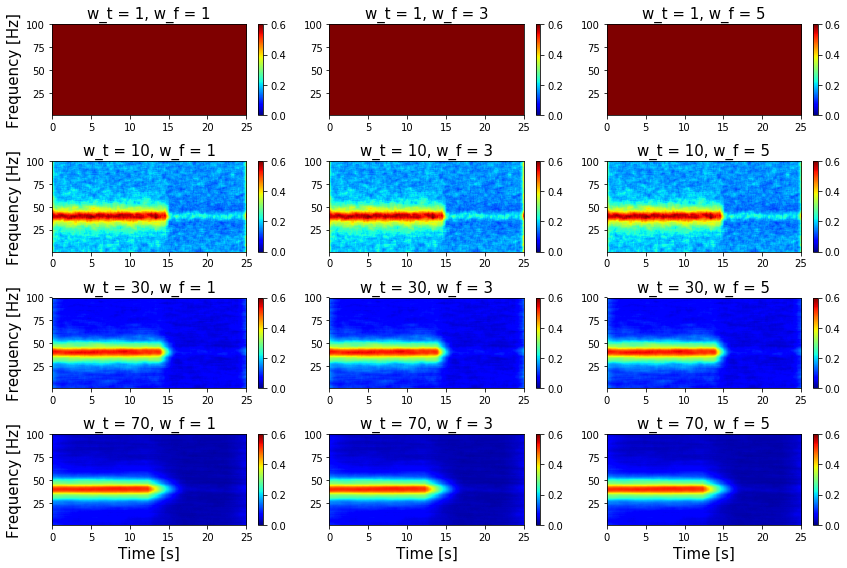

In [7]:
plt.figure(figsize=(12,8))
count = 1
for i in range(len(win_time)):
    for j in range(len(win_freq)):
        time_frequency.wavelet_coherence(data = X.values, pairs = np.array([[0,1]]), fs = Fs, 
                                 freqs = freqs, n_cycles = freqs/2, time_bandwidth = 8.0, 
                                 delta = 15, method = 'multitaper', win_time = win_time[i], win_freq = win_freq[j], 
                                 dir_out = 'data', n_jobs = -1)

        with h5py.File('data/ch1_0_ch2_1.h5', 'r') as hf:
            coh = np.array(hf.get('coherence'))
            
        plt.subplot(len(win_time), len(win_freq), count)
        plt.imshow(coh.mean(axis=0), aspect='auto', cmap='jet', origin='lower',
                   extent=[X.time[0],X.time[-1],freqs[0], freqs[-1]], vmin=0, vmax=0.6)
        if j==0: plt.ylabel('Frequency [Hz]', fontsize=15)
        if i==3: plt.xlabel('Time [s]', fontsize=15)
        plt.title('w_t = ' + str(win_time[i]) + ', w_f = ' + str(win_freq[j]), fontsize=15)
        plt.colorbar()
        count += 1
plt.tight_layout()
plt.savefig('coh_test_multitaper.pdf', dpi = 600)

### Estimating coherence for broadbands using Multitaper method

To estimate the coherence (or spectra) in given bands we can use the multitaper method. Supose that we have the center frequencies of each band $f_c = \{f_{0},\dots, f_{n}\}$, where $n$ is the number of bands, and the bandwidth of each band $\delta f = \{\delta f_{0},\dots,\delta f_{n}\}$.

If $t_b$ is the time bandwidth of the Multitaper transform, the number of cycles can be computed by:

$n_\rm{cycles} = t_b\frac{f_c}{\delta f}$

This can be used to compute the spctra (and the coherence) directly in each band of interest.

For this example using the toy model, let's supose that:

$f_c = \{12.5, 37.5, 62.5, 87.5\}$, and

 $\delta f = \{12.5, 12.5, 12.5, 12.5\}$
 
 If we set $t_b = 8.0$, the number of cycles will be $n_\rm{cycles} = 8.0\frac{f_c}{12.5} =\{8, 24, 40, 56\}$

In [7]:
bands = ['0-25Hz','25-50Hz', '50-75Hz','75-100Hz']
f_c = np.array([12.5,37.5,62.5,87.5])
d_f = np.ones_like(f_c) * 12.5
t_b = 8.0
n_cycles = t_b * f_c / d_f

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.9s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.7s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.8s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parall

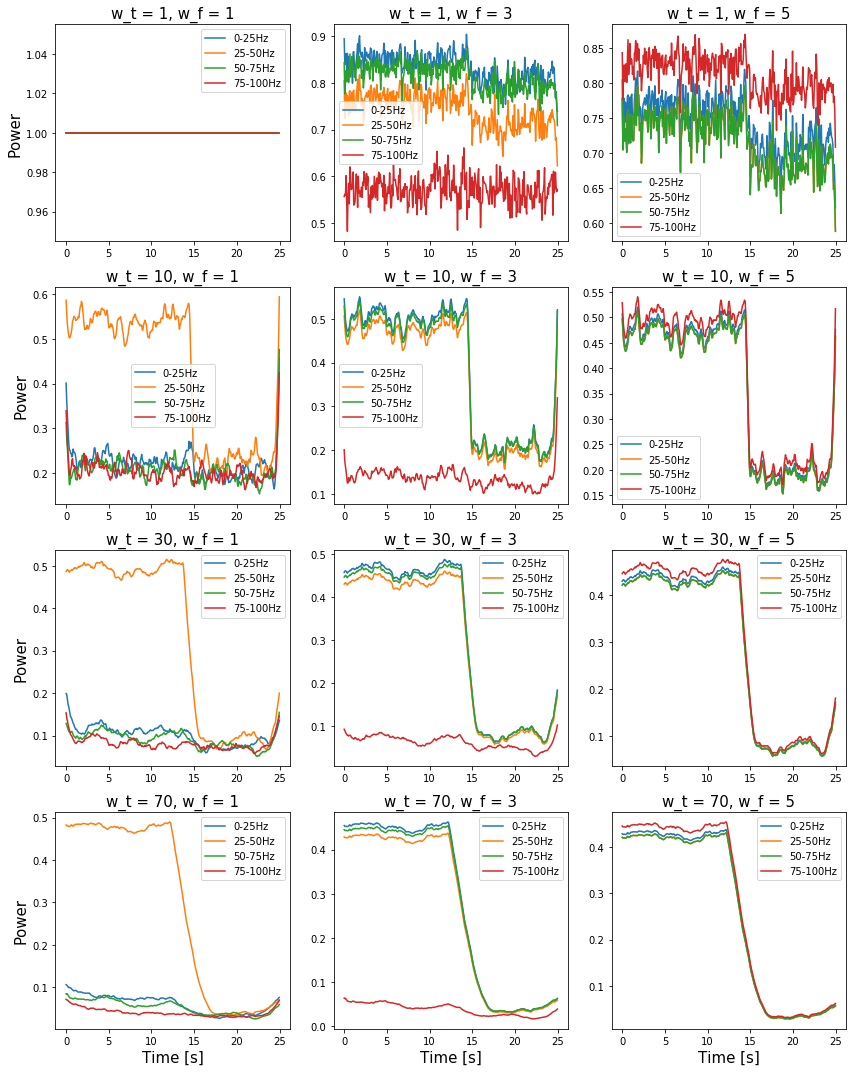

In [10]:
plt.figure(figsize=(12,15))
count = 1
for i in range(len(win_time)):
    for j in range(len(win_freq)):
        time_frequency.wavelet_coherence(data = X.values, pairs = np.array([[0,1]]), fs = Fs, 
                                 freqs = f_c, n_cycles = n_cycles, time_bandwidth = t_b, 
                                 delta = 15, method = 'multitaper', win_time = win_time[i], win_freq = win_freq[j], 
                                 dir_out = 'data', n_jobs = -1)

        with h5py.File('data/ch1_0_ch2_1.h5', 'r') as hf:
            coh = xr.DataArray( np.array(hf.get('coherence')),
                                dims = ('trials', 'f_c', 'time'),
                                coords = {'time': (np.arange(N)*dt)[::15]})
            
        plt.subplot(len(win_time), len(win_freq), count)
        for b in range(len(f_c)):
            plt.plot(coh.time, coh.mean(dim='trials')[b,:], label = bands[b])
            if j==0: plt.ylabel('Power', fontsize=15)
            if i==3: plt.xlabel('Time [s]', fontsize=15)
            plt.title('w_t = ' + str(win_time[i]) + ', w_f = ' + str(win_freq[j]), fontsize=15)
            plt.legend()
        count += 1
plt.tight_layout()
plt.savefig('coh_bands_multitaper.pdf', dpi = 600)

As expected using $w_f>1$ is not good because it averages over bands creating artificial peaks. And big values of $w_t$ results in poor temporal resolution of events, for instance for $w_t=70$ the moment when the coupling between $X_1(t)$ and $X_2(t)$ is turned off is not well located in time.

### Single-trial coherence estimation using Multitaper method

For this example we will set $w_t = 10$ and $w_f=1$ based on the results in the plot above.

In [21]:
w_t = 10
w_f = 1

In [22]:
time_frequency.wavelet_coherence(data = X.values, pairs = np.array([[0,1]]), fs = Fs, 
                                 freqs = f_c, n_cycles = n_cycles, time_bandwidth = t_b, 
                                 delta = 15, method = 'multitaper', win_time = w_t, win_freq = w_f, 
                                 dir_out = 'data', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    2.8s finished


In [23]:
with h5py.File('data/ch1_0_ch2_1.h5', 'r') as hf:
    coh = xr.DataArray( np.array(hf.get('coherence')),
                        dims = ('trials', 'f_c', 'time'),
                        coords = {'time': (np.arange(N)*dt)[::15]})

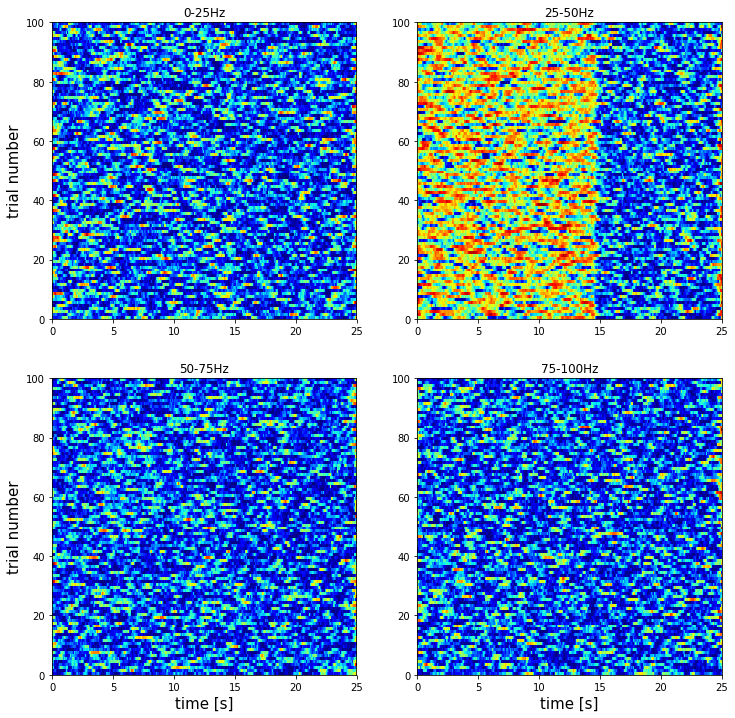

In [26]:
plt.figure(figsize=(12,12))
for i in range(len(f_c)):
    plt.subplot(2,2,i+1)
    plt.imshow(coh.sel(f_c=i), aspect='auto',cmap='jet',origin='lower',extent=[coh.time[0], coh.time[-1],0,Trials])
    if i==0 or i==2: plt.ylabel('trial number', fontsize=15)
    if i==2 or i == 3: plt.xlabel('time [s]', fontsize=15)
    plt.title(bands[i])

In [10]:
a = np.sin( 2*np.pi*8*np.arange(1000)/1000  + int(False)*np.random.rand(10, 2, 1)*2 *np.pi )

In [76]:
a.shape

(10, 2, 1000)

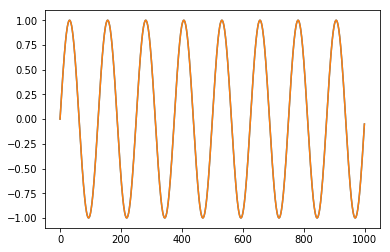

In [77]:
plt.plot(a[0,0,:])
plt.plot(a[9,1,:])

In [85]:
peaktime=np.array([.5])
width   = np.array([.1])

In [86]:
gaus  = np.sum( np.exp( -(np.arange(1000)/1000-peaktime[:,np.newaxis]).T**2 / (2*width**2) ), axis=1)

In [87]:
gaus.shape

(1000,)

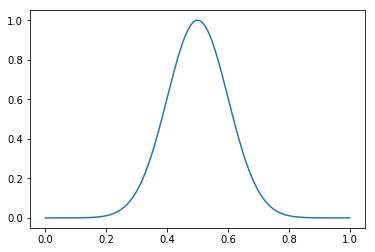

In [88]:
plt.plot(np.arange(1000)/1000,gaus)

In [89]:
signal = gaus[None,None,:]*a

In [90]:
signal.shape

(10, 2, 1000)

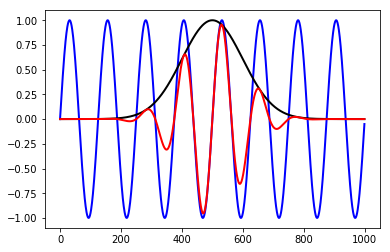

In [94]:
plt.plot(a[0,0,:], 'b', lw=2)
plt.plot(gaus, 'k', lw=2)
plt.plot(signal[0,0,:], 'r', lw=2)

In [62]:
a.shape

(10, 2, 1000)

In [7]:
type(signal)

xarray.core.dataarray.DataArray

In [11]:
assert type(a)==xr.core.dataarray.DataArray, 'Data should be an xarray'

AssertionError: Data should be an xarray

In [59]:
from mne.connectivity import spectral_connectivity

In [61]:
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(signal.values, method='coh',sfreq=fs,n_jobs=-1)



Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1 connections
    using t=0.000s..3.996s for estimation (1000 points)
    frequencies: 1.2Hz..125.0Hz (496 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..1


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 2..2


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 3..3


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 4..4


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 5..5


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 6..6


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 7..7


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 8..8


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 9..9


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    computing connectivity for epochs 10..10


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.


    assembling connectivity matrix (filling the upper triangular region of the matrix)
[Connectivity computation done]


[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.2s finished


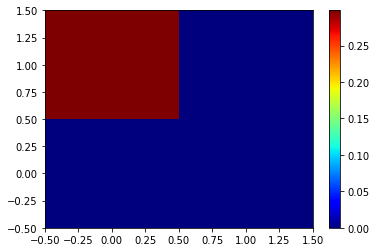

In [65]:
plt.imshow(con[:,:,0], aspect='auto', cmap='jet', origin='lower');plt.colorbar()

In [51]:
win_time=2
gaus   = np.exp( -(np.linspace(-win_time*10, 10*win_time+1,100)**2 / (2*win_time**2) ) )

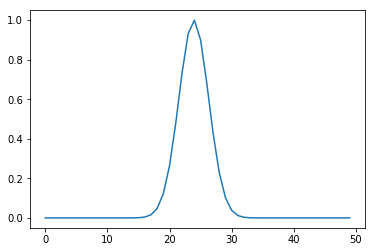

In [52]:
plt.plot(gaus)